In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# Step 1: Load the model
model = load_model('data/out/modelos/predictor_gasto_farmacia.keras')

# Create output directory if it doesn't exist
output_dir = 'data/out/resultados'

In [2]:
# Step 2: Load the data (assuming you're using the same data structure as before)
# Replace this with the correct path to your data
eceg_2020_mun = pd.read_csv('data/out/eceg_2020_mun.csv')
enigh_2022_mun = pd.read_csv('data/out/enigh_2022_mun_pol.csv')

In [3]:
enigh_2022_mun

,medicinas,cuida_pers,est_socio,ing_cor,entidad,municipio
0,370513.390000,3.901444e+06,2.714378,1.238243e+08,1,1
1,32014.210000,3.579400e+05,2.000000,9.133303e+06,1,2
2,46294.480000,3.280608e+05,2.000000,1.030639e+07,1,3
3,3553.960000,5.109968e+04,2.000000,7.592749e+05,1,4
4,78173.010000,7.372831e+05,2.268199,1.968148e+07,1,5
...,...,...,...,...,...,...
2470,46597.673333,4.896170e+05,2.632047,1.238122e+07,32,37
2471,4442.536667,7.189031e+04,1.667105,1.728795e+06,32,41
2472,16680.560000,1.022269e+05,2.200647,2.529844e+06,32,43
2473,3445.706667,4.207420e+04,1.666667,9.802428e+05,32,47


In [4]:

# Step 3: Preprocess the data
# Rename columns for consistency
enigh_2022_mun.rename(columns={'CVE_MUN':'municipio','CVE_ENT':'entidad'}, inplace=True)


In [5]:
XY = pd.merge(enigh_2022_mun, eceg_2020_mun, on=['municipio', 'entidad'], how='inner')


In [6]:
# Step 4: Prepare input features (X)
X_new = XY.loc[:, ["medicinas", "cuida_pers", "pobtot", "p_0a2", "pder_ss", "pocupada", "ing_cor"]]


In [7]:

# Standardize the features (same scaling as during training)
scaler = StandardScaler()
X_scaled_new = scaler.fit_transform(X_new)

# Step 5: Make predictions
predictions = model.predict(X_scaled_new)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


In [8]:
predictions

array([[1877035.   ],
       [ 121317.14 ],
       [ 140597.31 ],
       ...,
       [  43015.96 ],
       [  37819.188],
       [  37869.785]], dtype=float32)

In [9]:
XY['gasto_farmacia_2026'] = predictions

In [10]:
enigh_2022_mun

,medicinas,cuida_pers,est_socio,ing_cor,entidad,municipio
0,370513.390000,3.901444e+06,2.714378,1.238243e+08,1,1
1,32014.210000,3.579400e+05,2.000000,9.133303e+06,1,2
2,46294.480000,3.280608e+05,2.000000,1.030639e+07,1,3
3,3553.960000,5.109968e+04,2.000000,7.592749e+05,1,4
4,78173.010000,7.372831e+05,2.268199,1.968148e+07,1,5
...,...,...,...,...,...,...
2470,46597.673333,4.896170e+05,2.632047,1.238122e+07,32,37
2471,4442.536667,7.189031e+04,1.667105,1.728795e+06,32,41
2472,16680.560000,1.022269e+05,2.200647,2.529844e+06,32,43
2473,3445.706667,4.207420e+04,1.666667,9.802428e+05,32,47


In [11]:
cambio_en_gasto=pd.merge(XY, enigh_2022_mun, on=['municipio', 'entidad'], how='inner')[["gasto_farmacia_2026","medicinas_y","cuida_pers_y","entidad","municipio"]]

In [12]:
cambio_en_gasto["cambio_gasto"] = (cambio_en_gasto["gasto_farmacia_2026"] - cambio_en_gasto["medicinas_y"] - cambio_en_gasto["cuida_pers_y"])/2

In [13]:
# order by cambio_gasto
cambio_en_gasto.sort_values(by="cambio_gasto", ascending=False)

,gasto_farmacia_2026,medicinas_y,cuida_pers_y,entidad,municipio,cambio_gasto
177,1434127.750,78430.24,507578.99,9,7,4.240593e+05
419,1257978.000,25193.56,474724.97,15,33,3.790297e+05
175,902804.250,18162.21,319234.97,9,5,2.827035e+05
433,838452.750,34954.25,398907.08,15,58,2.022957e+05
432,663423.125,38013.74,311746.00,15,57,1.568317e+05
...,...,...,...,...,...,...
11,1788925.375,268560.54,3671107.75,2,2,-1.075371e+06
18,1146108.500,188763.29,3128842.01,3,8,-1.085748e+06
0,1877035.000,370513.39,3901444.10,1,1,-1.197461e+06
774,1891043.500,444132.45,3993651.38,22,14,-1.273370e+06


In [14]:
denue_2020=pd.read_csv('data/out/denue_2020_mun.csv')

In [15]:
cobertura_gasto_farm_2022=(cambio_en_gasto["medicinas_y"].sum() + cambio_en_gasto["cuida_pers_y"].sum())/denue_2020["num_empresas"].sum()

In [16]:
# Step 1: Calculate the total coverage needed
total_pharmacy_coverage = 200 * cobertura_gasto_farm_2022

# Step 2: Sort municipalities by the largest 'cambio_gasto'
cambio_en_gasto_sorted = cambio_en_gasto.sort_values(by="cambio_gasto", ascending=False)

# Step 3: Initialize a column to store the number of pharmacies assigned to each municipality
cambio_en_gasto_sorted['farmacias_asignadas'] = 0

# Step 4: Initialize the cumulative sum of assigned pharmacies
cumulative_pharmacy_coverage = 0

# Step 5: Iterate over the municipalities and assign pharmacies based on 'cambio_gasto'
for index, row in cambio_en_gasto_sorted.iterrows():
    # Calculate the number of pharmacies to assign to this municipality
    assigned_pharmacies = (row['cambio_gasto'] / total_pharmacy_coverage) * 200
    
    # Check if adding these pharmacies would exceed the total of 200
    if cumulative_pharmacy_coverage + assigned_pharmacies > 200:
        # Assign only the remaining pharmacies needed to reach 200
        assigned_pharmacies = 200 - cumulative_pharmacy_coverage
    
    # Assign the pharmacies to the municipality
    cambio_en_gasto_sorted.at[index, 'farmacias_asignadas'] = assigned_pharmacies
    
    # Update the cumulative sum of pharmacies assigned
    cumulative_pharmacy_coverage += assigned_pharmacies
    
    # Stop if we have assigned all 200 pharmacies
    if cumulative_pharmacy_coverage >= 200:
        break

# Step 6: Show the results
print(cambio_en_gasto_sorted[['entidad', 'municipio', 'cambio_gasto', 'farmacias_asignadas']])


     entidad  municipio  cambio_gasto  farmacias_asignadas
177        9          7  4.240593e+05            73.684632
419       15         33  3.790297e+05            65.860292
175        9          5  2.827035e+05            49.122630
433       15         58  2.022957e+05            11.332446
432       15         57  1.568317e+05             0.000000
..       ...        ...           ...                  ...
11         2          2 -1.075371e+06             0.000000
18         3          8 -1.085748e+06             0.000000
0          1          1 -1.197461e+06             0.000000
774       22         14 -1.273370e+06             0.000000
13         2          4 -1.282136e+06             0.000000

[2456 rows x 4 columns]


C:\Users\samue\AppData\Local\Temp\ipykernel_13356\4223186182.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '73.68463220291451' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cambio_en_gasto_sorted.at[index, 'farmacias_asignadas'] = assigned_pharmacies


In [17]:
# Step 1: Select the top 10 municipalities with the highest 'cambio_gasto'
top_10_municipalities = cambio_en_gasto_sorted.head(30).copy()

# Step 2: Calculate the total 'cambio_gasto' for the top 10 municipalities
total_cambio_gasto_top_10 = top_10_municipalities['cambio_gasto'].sum()

# Step 3: Initialize a column to store the number of pharmacies assigned
top_10_municipalities['farmacias_asignadas'] = 0

# Step 4: Distribute pharmacies proportionally based on 'cambio_gasto'
cumulative_pharmacies_assigned = 0

for index, row in top_10_municipalities.iterrows():
    # Calculate the proportion of pharmacies based on 'cambio_gasto'
    assigned_pharmacies = (row['cambio_gasto'] / total_cambio_gasto_top_10) * 200
    
    # Round the number of pharmacies and ensure it's an integer
    assigned_pharmacies = np.floor(assigned_pharmacies)
    
    # Assign pharmacies to the municipality
    top_10_municipalities.at[index, 'farmacias_asignadas'] = assigned_pharmacies
    
    # Keep track of cumulative pharmacies assigned
    cumulative_pharmacies_assigned += assigned_pharmacies

# Step 5: Ensure that the total number of assigned pharmacies equals 200
# If due to rounding we have fewer than 200, add the difference to the municipality with the largest 'cambio_gasto'
if cumulative_pharmacies_assigned < 200:
    difference = 200 - cumulative_pharmacies_assigned
    top_10_municipalities.iloc[0, top_10_municipalities.columns.get_loc('farmacias_asignadas')] += difference

# Step 6: Display the result
top_10_municipalities=top_10_municipalities[['entidad', 'municipio', 'cambio_gasto', 'farmacias_asignadas']]


In [18]:
import geopandas as gpd

mun_grouped = gpd.read_file(r'data\out\mun_grouped\mun_grouped.shp')

In [19]:
mun_grouped.rename(columns={'CVE_MUN':'municipio','CVE_ENT':'entidad'}, inplace=True)
top_10_municipalities["entidad"] = top_10_municipalities["entidad"].astype(int)
top_10_municipalities["municipio"] = top_10_municipalities["municipio"].astype(int)
mun_grouped["entidad"] = mun_grouped["entidad"].astype(int)
mun_grouped["municipio"] = mun_grouped["municipio"].astype(int)

In [20]:
mun_grouped_gast = mun_grouped.merge(cambio_en_gasto, on=['entidad', 'municipio'], how='left')

In [21]:
#fill 0 in cambio_gasto
mun_grouped_gast['cambio_gasto'] = mun_grouped_gast['cambio_gasto'].fillna(0)

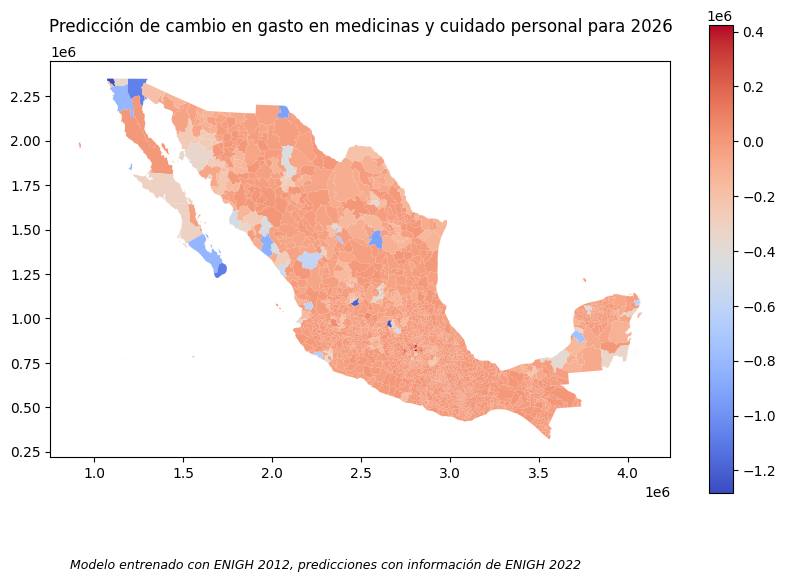

In [22]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the data with 'cambio_gasto' using the 'coolwarm' colormap
mun_grouped_gast.plot(column='cambio_gasto', legend=True, cmap='coolwarm', ax=ax,
                      legend_kwds={'shrink': 0.6})  # Reduce the size of the legend

# Set the main title with smaller font size
ax.set_title('Predicción de cambio en gasto en medicinas y cuidado personal para 2026', 
             fontsize=12, pad=10)

# Adjust the layout to reduce space between plot and the edge
plt.subplots_adjust(bottom=0.1)

# Add additional notes just beneath the map
plt.figtext(0.4, 0.18, 'Modelo entrenado con ENIGH 2012, predicciones con información de ENIGH 2022', 
            ha='center', fontsize=9, style='italic')

plt.savefig(f'{output_dir}/cambio_en_gasto_nacional.png')

# Show the plot
plt.show()


In [25]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Create output directory if it doesn't exist
output_dir = 'data/out/resultados'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Ensure 'entidad' and 'municipio' are integers for merging
top_10_municipalities["entidad"] = top_10_municipalities["entidad"].astype(int)
top_10_municipalities["municipio"] = top_10_municipalities["municipio"].astype(int)
mun_grouped["entidad"] = mun_grouped["entidad"].astype(int)
mun_grouped["municipio"] = mun_grouped["municipio"].astype(int)

# Merge to get the geographic boundaries and pharmacy assignment data
mun_grouped_gast = mun_grouped.merge(top_10_municipalities, on=['entidad', 'municipio'], how='left')

# Fill NaN values in 'farmacias_asignadas' with 0 for municipalities that are not in the top 10
mun_grouped_gast['farmacias_asignadas'] = mun_grouped_gast['farmacias_asignadas'].fillna(0)

# Dictionary to map INEGI Entidad codes to names
entidad_names = {
    1: "Aguascalientes", 2: "Baja California", 3: "Baja California Sur", 4: "Campeche",
    5: "Coahuila", 6: "Colima", 7: "Chiapas", 8: "Chihuahua", 9: "Ciudad de México",
    10: "Durango", 11: "Guanajuato", 12: "Guerrero", 13: "Hidalgo", 14: "Jalisco", 
    15: "Estado de México", 16: "Michoacán", 17: "Morelos", 18: "Nayarit", 19: "Nuevo León", 
    20: "Oaxaca", 21: "Puebla", 22: "Querétaro", 23: "Quintana Roo", 24: "San Luis Potosí", 
    25: "Sinaloa", 26: "Sonora", 27: "Tabasco", 28: "Tamaulipas", 29: "Tlaxcala", 
    30: "Veracruz", 31: "Yucatán", 32: "Zacatecas"
}

# Step 1: Get the unique list of 'entidad' values from the top 30 municipalities
unique_entidades = top_10_municipalities['entidad'].unique()

# Step 2: Iterate over each 'entidad' and generate a map, then save the plot
for entidad in unique_entidades:
    # Filter the data for the current 'entidad'
    entidad_mun_gast = mun_grouped_gast[mun_grouped_gast['entidad'] == entidad]
    
    # Calculate the total number of pharmacies assigned in this entidad
    total_farmacias = entidad_mun_gast['farmacias_asignadas'].sum()

    # Plot the map for the current 'entidad'
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plot the municipalities in the current 'entidad' in red
    entidad_mun_gast.plot(ax=ax, column='farmacias_asignadas', cmap='Reds', legend=True, 
                          legend_kwds={'label': "Farmacias Asignadas", 'orientation': "horizontal"})
    
    # Add labels for the number of pharmacies assigned, with smaller font size (e.g., 8)
    for x, y, label in zip(entidad_mun_gast.geometry.centroid.x, 
                           entidad_mun_gast.geometry.centroid.y, 
                           entidad_mun_gast['farmacias_asignadas']):
        ax.text(x, y, int(label), fontsize=8, ha='center', color='black')  # Smaller font size
    
    # Set title, using the entidad code to look up the name, and adding total pharmacies assigned
    entidad_name = entidad_names.get(entidad, f"Entidad {entidad}")
    ax.set_title(f'{entidad_name}  - Farmacias Asignadas: {int(total_farmacias)}', fontsize=16)

    # Save the plot to the output directory
    plt.savefig(f'{output_dir}/{entidad_name}_farmacias_asignadas.png')

    # Close the plot to avoid displaying it in the loop
    plt.close()

# Step 6: Save the top 30 municipalities with pharmacies to CSV
top_10_municipalities.to_csv(f'{output_dir}/top_30_municipalities.csv', index=False)

print(f"Graphs and CSV saved to {output_dir}")


Graphs and CSV saved to data/out/resultados


In [24]:
top_10_municipalities.to_csv(f'{output_dir}/top_30_municipalities.csv', index=False)